# Week 10 Exercise
## SpliceAI Dataset Construction for RNA Splicing Prediction

In this exercise you will implement a **SpliceAI data preprocessing pipeline** for RNA splicing prediction.

You will:
1. Download the human reference genome FASTA and gene annotation GTF.
2. Extract protein-coding exons and derive donor/acceptor splice sites.
3. Build fixed-length input windows and local label blocks around genomic positions.
4. Split the dataset by chromosome (train: chr20, val: chr21, test: chr22).
5. Visualize example windows to verify correctness.

Only edit the cells explicitly marked as **Exercise**.

### Environment, imports, and paths
**DO NOT MODIFY:**

In [1]:
# %matplotlib inline # 첫 번째 줄에서 %matplotlib inline 의 역할은 notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것 입니다.

import os, random
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 13})

SEED = 42
random.seed(SEED); np.random.seed(SEED)
DS = 50
# 수정! /Users/martin/Desktop/PythonWorkSpace/data

DATA_DIR = Path("/Users/martin/Desktop/PythonWorkSpace/spliceai_data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

### Install dependencies
**DO NOT MODIFY:** `pyfaidx` allows efficient access to the FASTA file.

In [2]:
# !pip install pyfaidx
# conda install bioconda::pyfaidx

### Download GRCh38 FASTA & GTF (GENCODE v46)
**DO NOT MODIFY:** Download may take a while.
- Download시 Colab등이 아닌 local환경에서는 error가 빈번함.
- local에서 받고자 한다면 Colab에서 실행시켜 받고 -> Colab GoogleDrive연동 -> GoogleDrive에서 받길 바람

In [3]:
GENCODE_FA_URL = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/GRCh38.primary_assembly.genome.fa.gz"
GENCODE_GTF_URL = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/gencode.v46.primary_assembly.basic.annotation.gtf.gz"

fa_gz = str((DATA_DIR / "GRCh38.primary_assembly.genome.fa.gz").resolve())
gtf_gz = str((DATA_DIR / "gencode.v46.primary_assembly.annotation.gtf.gz").resolve())

print("Downloading (skip if exists)...")
if not os.path.exists(fa_gz):
    !wget -O "$fa_gz" "$GENCODE_FA_URL"
else:
    print("FASTA already exists:", fa_gz)
if not os.path.exists(gtf_gz):
    !wget -O "$gtf_gz" "$GENCODE_GTF_URL"
else:
    print("GTF already exists:", gtf_gz)

fa = fa_gz[:-3]
gtf = gtf_gz[:-3]

if not os.path.exists(fa):
    !gunzip -c "$fa_gz" > "$fa"
if not os.path.exists(gtf):
    !gunzip -c "$gtf_gz" > "$gtf"

print("FASTA:", fa)
print("GTF  :", gtf)


FASTA already exists: /Users/martin/Desktop/PythonWorkSpace/spliceai_data/GRCh38.primary_assembly.genome.fa.gz
GTF already exists: /Users/martin/Desktop/PythonWorkSpace/spliceai_data/gencode.v46.primary_assembly.annotation.gtf.gz
FASTA: /Users/martin/Desktop/PythonWorkSpace/spliceai_data/GRCh38.primary_assembly.genome.fa
GTF  : /Users/martin/Desktop/PythonWorkSpace/spliceai_data/gencode.v46.primary_assembly.annotation.gtf



### FASTA parsing


**Exercise:** implement `revcomp`, which takes (uppercase) DNA sequence and returns its reverse complement.

In [4]:
complement_doc = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
def revcomp(seq: str) -> str: # AT, CG
    ## YOUR CODE HERE ##
    return ''.join(complement_doc.get(b, 'N') for b in reversed(seq))

In [5]:
re_seq = revcomp('CTTGATCAT')
print(re_seq)

ATGATCAAG


**DO NOT MODIFY:** Read FASTA and fetch sequences on demand.

In [6]:
from pyfaidx import Fasta
FA_IDX = Fasta(fa, as_raw=True, sequence_always_upper=True)

def _resolve_chrom_key(chrom: str, keys) -> str:
    """Return a key present in FA_IDX matching chrom, tolerating chr/no-chr prefixes."""
    if chrom in keys:
        return chrom
    if chrom.startswith("chr") and chrom[3:] in keys:
        return chrom[3:]
    prefixed = "chr" + chrom
    if prefixed in keys:
        return prefixed
    raise KeyError(f"Chromosome '{chrom}' not found in FASTA index. Available examples: {list(keys)[:5]}")

def fetch_seq(chrom: str, start: int, end: int, strand: str = '+') -> str:
    """
    Return uppercase sequence for 0-based half-open [start, end).
    """
    key = _resolve_chrom_key(chrom, FA_IDX.keys() if hasattr(FA_IDX, "keys") else FA_IDX)
    rec = FA_IDX[key]
    seq = rec[start:end]
    seq = seq.upper()
    if strand == '-': # 자동으로 strand 바꿔줌!!
        seq = revcomp(seq)
    return seq

### GTF parsing
**DO NOT MODIFY:** Parses a GTF file and returns a dictionary of exons, with tuple `(chromosome, strand, transcript_id)` as key and list of exon coordinates (length-2 list `[exon_start,exon_end]`) as values.\
**NOTE:** Only Chromosome 20, 21, and 22 will be used to save time.

In [7]:
def extract_exons_from_gtf(path):
    colnames = ["seqname","source","feature","start","end","score","strand","frame","attribute"]
    gtf_df = pd.read_csv(path, sep="\t", comment="#", names=colnames, dtype={"seqname": str})

    # If we used the fallback above, we need to extract a few attributes
    if "gene_type" not in gtf_df.columns or "transcript_id" not in gtf_df.columns:
        def _attr_get(s, key):
            if not isinstance(s, str): return None
            parts = [p.strip() for p in s.split(";") if p.strip()]
            for p in parts:
                # keys can be gene_type "protein_coding"; or gene_biotype "protein_coding"
                if p.startswith(key + " "):
                    bits = p.split('"')
                    if len(bits) >= 2:
                        return bits[1]
            return None
        if "attribute" in gtf_df.columns:
            if "gene_type" not in gtf_df.columns:
                gtf_df["gene_type"] = gtf_df["attribute"].apply(lambda s: _attr_get(s, "gene_type") or _attr_get(s, "gene_biotype"))
            if "transcript_id" not in gtf_df.columns:
                gtf_df["transcript_id"] = gtf_df["attribute"].apply(lambda s: _attr_get(s, "transcript_id"))

    # Filter exons and biotypes
    exons = gtf_df[gtf_df["feature"]=="exon"].copy()
    exons = exons[exons["attribute"].str.contains("Ensembl_canonical")].copy()
    gene_type_col = "gene_type" if "gene_type" in exons.columns else ("gene_biotype" if "gene_biotype" in exons.columns else None)
    if gene_type_col is not None:
        exons = exons[exons[gene_type_col].fillna("")=="protein_coding"]

    _TARGETS = {"20", "21", "22", "chr20", "chr21", "chr22"}
    exons = exons[exons["seqname"].astype(str).isin(_TARGETS)].copy()

    out = {}
    for (chrom, strand, tid), grp in exons.groupby(["seqname","strand","transcript_id"], dropna=True):
        if tid is None or pd.isna(tid):
            continue
        ex = grp[["start","end"]].astype(int).values.tolist()
        ex.sort(key=lambda x: x[0])
        out[(str(chrom), str(strand), str(tid))] = ex
    return out

transcripts_dict = extract_exons_from_gtf(gtf)

### Finding splice sites from exon information
**Exercise:** implement `build_splice_labels_from_exons`. It should return `donor_sites` and `acceptor_sites` dictionary. These dictionaries take tuple `(chrom, strand)` as key, and **sorted** list of donor/acceptor site positions as key. **Beware of strand handling.**

In [8]:
# print(transcripts_dict)
# chr#: n번째 chromosome에 포함된
# +: forward strand, -: reverse strand
# tid:

In [9]:
def build_splice_labels_from_exons(transcripts):
    # STUDENT TODO:
    donor_sites, acceptor_sites = {}, {}
    for (chrom, strand, tid), exons in transcripts.items():
        ## YOUR CODE HERE ##
        # chrom: chrom20, 21, 22
        # strand +(forward), -(reverse)
        # tid
        # exon이 위치한 범위 둘다 포함한 범위임을 유의?
        exons_np = np.array(exons)
        # + forward strand일때를 가정
        # doner site = exon의 끝, 마지막 exon을 제외
        # acceptor site = exon의 시작점, 첫 exon을 제외
        d_list, a_list = [], []
        if strand == "+": # strand에 따라 array번호가 다름
            d_list = list(exons_np[:-1,1]) # 마지막 제외
            a_list = list(exons_np[1:,0]) # 처음 제외
        else:
            d_list = list(exons_np[1:,0] - 1) # 아 씨발 -1ㅋㅋㅋㅋ
            a_list = list(exons_np[:-1,1] - 1)

        donor_sites[(chrom,strand)] = sorted(set(donor_sites.get((chrom,strand), []) + d_list))
        acceptor_sites[(chrom,strand)] = sorted(set(acceptor_sites.get((chrom,strand), []) + a_list))

    return donor_sites, acceptor_sites


donor_sites, acceptor_sites = build_splice_labels_from_exons(transcripts_dict)

In [10]:
# array = np.array([[1,2],[3,4],[5,6],[7,8],[9,10]])
# print(array[:-1,1]) # doner site
# print(array[1:,0]) # acceptor site
# ex = np.array([[33007704, 33007760], [33008541, 33008683], [33011024, 33011117], [33012803, 33012907], [33013810, 33013956], [33015436, 33015496], [33017042, 33017102], [33018259, 33018350], [33018637, 33018822], [33019062, 33019115], [33019580, 33019750], [33020328, 33020395], [33020542, 33020587], [33021281, 33021344], [33021723, 33021799], [33023342, 33023703]])
# print(ex[:-1,1])

### One-hot encoding and label vectors (**student TODOs**)

**Exercise**: Implement one-hot encoding of DNA (A, C, G, T). Any other alphabets should be represented as [0,0,0,0] (full zero).
- A: [1,0,0,0]
- C; [0,1,0,0]
- G: [0,0,1,0]
- T: [0,0,0,1]

In [11]:
def one_hot_encode(seq: str):
    ## return X with shape (len(seq), 4) with channels A,C,G,T
    ## YOUR CODE HERE ##
    m = {'A':0, 'C':1, 'G':2, 'T':3}
    L = len(seq)
    X = np.zeros((L,4), dtype=np.float32)
    for i, ch in enumerate(seq.upper()):
        j = m.get(ch)
        if j is not None:   # A/C/G/T면 해당 열을 1로
            X[i, j] = 1.0   # N 등은 그대로 0 0 0 0
    return X


**Exercise**: Implement one-hot encoding of the label (Neither, Donor, Acceptor).

In [12]:
# print(center_pos) -> 10413708
# print(donor_list) -> [10413708 10420528 10434108]
# print(acceptor_list) -> [10413931 10420758 10434222]
# print(DS) -> 50
def label_vector(center_pos, donor_list, acceptor_list, DS=DS):
    # return y with shape (3, 2*DS+1) where channel 0 = neither, 1=donor, 2=acceptor
    # reverse상관없이 5'->3'으로 들어온다고 가정하는건가?
    # center_pos가 진짜 중앙임?
    y = np.zeros((3, 2*DS), dtype=np.uint8)
    # 왜 이렇게 생각하지 못했을까
    # 이리 단순한걸...
    for p in donor_list:
        d = p - center_pos
        if -DS <= d < DS:
            y[1, d+DS] = 1


    for p in acceptor_list:
        d = p - center_pos
        if -DS <= d < DS:
            y[2, d+DS] = 1

    y[0] = ((y[1]+y[2])==0).astype(np.uint8) # 아!..
    return y

In [13]:
# print(np.zeros((3,2*50+1)))
# a = np.array([100])
# b = np.array([105,10,107])
# print(a<b)
# if np.all(100 < b): print('aaa')
# else: print('bbb')

### Window extraction and parameters
**DO NOT MODIFY:** Given the coordinate, extracts sequence and pads it if needed. We use a manageable context length (**CL**) and a local label radius (**DS**) for short runtime.


In [14]:
CL = 20
DS = 10
assert CL % 2 == 0
assert DS % 2 ==0

def extract_window_idx(chrom, center_pos_0b, strand='+', CL=CL, DS = DS):
    half = (CL+DS) // 2
    start = max(0, center_pos_0b - half)
    end = center_pos_0b + half
    seq = fetch_seq(chrom, start, end, strand=strand)
    # left pad if needed
    left_pad = half - (center_pos_0b - start)
    if left_pad > 0:
        seq = 'N' * left_pad + seq
    # right pad if short
    if len(seq) < CL:
        seq = seq + 'N' * (CL - len(seq))
    return seq


### Dataset assembly
**DO NOT MODIFY:** We sample candidate positions from donor/acceptor sets per (chrom,strand), extract windows, and construct (X, Y).\
**NOTE:** Unlike the original SpliceAI workflow that uses the whole primary sequence, we only sample a small number of windows around the donor and the acceptor sites to save time.


In [15]:
def get_sequences_and_labels(chrom, strand, positions, donor_sites, acceptor_sites, CL=CL, DS=DS):
    X_list, Y_list = [], []
    donor_list = donor_sites.get((chrom,strand), [])
    acceptor_list = acceptor_sites.get((chrom,strand), [])
    motif_donor = Counter()
    motif_acceptor = Counter()
    for pos in positions:
        seq = extract_window_idx(chrom, pos, strand=strand, CL=CL)
        X_list.append(one_hot_encode(seq))
        label = label_vector(pos, donor_list, acceptor_list, DS=DS)
        Y_list.append(label)
        if label[1,label.shape[1]//2] == 1:
            km = seq[len(seq)//2:len(seq)//2+2]
            motif_donor[km] += 1
        elif label[2,label.shape[1]//2] == 1:
            km = seq[len(seq)//2-3:len(seq)//2-1]
            motif_acceptor[km] += 1

    return X_list, Y_list, motif_donor, motif_acceptor


### Train/Val/Test split and save
**DO NOT MODIFY:** Deterministic set split based on chromosome. Save NPZ files.


In [16]:
# Define chromosome-based split (no randomness)
CHROM_SPLITS = {
    "train": {"20", "chr20"},
    "val":   {"21", "chr21"},
    "test":  {"22", "chr22"},
}

def _filter_pos_map_by_split(pos_map, split_name):
    # Keep only positions from chromosomes belonging to the given split.
    keep = CHROM_SPLITS[split_name]
    return {k: v for k, v in pos_map.items() if k[0] in keep}


def sample_positions(donor_sites, acceptor_sites, max_per_chrom=4000, rng=np.random.default_rng(SEED)):
    pos_map = {}
    for key in set(list(donor_sites.keys()) + list(acceptor_sites.keys())):
        donors = set(donor_sites.get(key, []))
        acceptors = set(acceptor_sites.get(key, []))
        all_pos = sorted(donors.union(acceptors))
        if len(all_pos) > max_per_chrom:
            idx = rng.choice(len(all_pos), size=max_per_chrom, replace=False)
            all_pos = [all_pos[i] for i in sorted(idx)]
        pos_map[key] = all_pos
    return pos_map

def create_dataset_per_split(transcripts_dict, CL=CL, DS=DS, max_per_chrom=4000):
    """
    Build datasets with fixed chromosome splits:
        train=chr20, val=chr21, test=chr22.
    Returns:
        (X_train, Y_train, ms_train), (X_val, Y_val, ms_val), (X_test, Y_test, ms_test)
    """
    # Compute donor/acceptor from the *provided* transcripts_dict (so scope is self-contained)
    donor_sites, acceptor_sites = build_splice_labels_from_exons(transcripts_dict)
    # Sample candidate positions per (chrom,strand)
    pos_map_all = sample_positions(donor_sites, acceptor_sites, max_per_chrom=max_per_chrom)

    results = {}
    for split_name in ("train", "val", "test"):
        pos_map = _filter_pos_map_by_split(pos_map_all, split_name)
        X_all, Y_all, motif_donor, motif_acceptor = [], [], Counter(), Counter()

        for (chrom, strand), positions in pos_map.items():
            X, Y, md, ma = get_sequences_and_labels(
                chrom, strand, positions,
                donor_sites=donor_sites, acceptor_sites=acceptor_sites,
                CL=CL, DS=DS
            )
            X_all.extend(X)
            Y_all.extend(Y)
            motif_donor.update(md)
            motif_acceptor.update(ma)

        results[split_name] = (X_all, Y_all, motif_donor, motif_acceptor)

    return results["train"], results["val"], results["test"]


def save_npz(path, X, Y):
    X = np.stack(X, axis=0)
    Y = np.stack(Y, axis=0)
    np.savez_compressed(path, X=X, Y=Y)
    pass


(X_train, Y_train, md_train, ma_train), (X_val, Y_val, md_val, ma_val), (X_test, Y_test, md_test, ma_test) = create_dataset_per_split(
    transcripts_dict, CL=CL, DS=DS, max_per_chrom=4000
)

save_npz(DATA_DIR / "train_chr20.npz", X_train, Y_train)
save_npz(DATA_DIR / "val_chr21.npz",   X_val,   Y_val)
save_npz(DATA_DIR / "test_chr22.npz",  X_test,  Y_test)

### Splice site counts (per chromosome-based split)

**DO NOT MODIFY:** Reports the number of **donor** and **acceptor** sites detected on chr20/21/22.

\
**COMPARE WITH EXPECTED RESULT:** \
train (chr20)    donors: 4486 acceptors: 4486\
val (chr21)      donors: 1781 acceptors: 1783\
test (chr22)     donors: 3830 acceptors: 3830

In [17]:
def _count_sites(donor_sites, acceptor_sites, chrom_set):
    dc = Counter(); ac = Counter()
    for (chrom, strand), arr in donor_sites.items():
        if chrom in chrom_set: dc[(chrom, strand)] += len(arr)
    for (chrom, strand), arr in acceptor_sites.items():
        if chrom in chrom_set: ac[(chrom, strand)] += len(arr)
    return dc, ac

CH20 = {"20", "chr20"}; CH21 = {"21", "chr21"}; CH22 = {"22", "chr22"}

if "donor_sites" in globals() and "acceptor_sites" in globals():
    for name, chroms in [("train (chr20)", CH20), ("val (chr21)", CH21), ("test (chr22)", CH22)]:
        dc, ac = _count_sites(donor_sites, acceptor_sites, chroms)
        print(f"{name:16s} donors:", sum(dc.values()), "acceptors:", sum(ac.values()))
else:
    print("donor_sites/acceptor_sites not in globals — run the GTF parsing cell first.")

train (chr20)    donors: 4486 acceptors: 4486
val (chr21)      donors: 1781 acceptors: 1783
test (chr22)     donors: 3830 acceptors: 3830


In [18]:
import pandas as pd

def get_smn2_exon7_sequence(gtf_path, chrom="5", gene="SMN2"):
    # 1. GTF 읽기
    colnames = ["seqname","source","feature","start",
                "end","score","strand","frame","attribute"]
    gtf_df = pd.read_csv(
        gtf_path,
        sep="\t",
        comment="#",
        names=colnames,
        dtype={"seqname": str}
    )

    # 2. attribute에서 gene_name, transcript_id 뽑기
    def _attr_get(s, key):
        if not isinstance(s, str):
            return None
        parts = [p.strip() for p in s.split(";") if p.strip()]
        for p in parts:
            if p.startswith(key + " "):
                bits = p.split('"')
                if len(bits) >= 2:
                    return bits[1]
        return None

    gtf_df["gene_name"]     = gtf_df["attribute"].apply(lambda s: _attr_get(s, "gene_name"))
    gtf_df["transcript_id"] = gtf_df["attribute"].apply(lambda s: _attr_get(s, "transcript_id"))

    # 3. SMN2 + chr5 + exon만 필터링
    base_mask = (
        (gtf_df["feature"] == "exon") &
        (gtf_df["gene_name"] == gene) &
        (gtf_df["seqname"].astype(str).isin([chrom, "chr" + chrom]))
    )
    exons = gtf_df[base_mask].copy()
    if exons.empty:
        raise ValueError("No SMN2 exons found on chromosome 5 in this GTF.")

    # 가능하면 Ensembl_canonical만 우선 사용, 없으면 전체 사용
    canon = exons[exons["attribute"].str.contains("Ensembl_canonical", na=False)].copy()
    if not canon.empty:
        exons = canon

    # 4. transcript별로 exon 리스트 만들기 (start 기준 정렬)
    transcripts = {}
    for tid, grp in exons.groupby("transcript_id", dropna=True):
        if tid is None or pd.isna(tid):
            continue
        strand = str(grp["strand"].iloc[0])
        chrom_val = str(grp["seqname"].iloc[0])
        ex_list = grp[["start", "end"]].astype(int).values.tolist()
        ex_list.sort(key=lambda x: x[0])  # 좌표 기준 오름차순
        if len(ex_list) >= 7:  # exon7까지 있으려면 최소 7개 필요
            transcripts[tid] = {
                "strand": strand,
                "chrom": chrom_val,
                "exons": ex_list,
            }

    if not transcripts:
        raise ValueError("No SMN2 transcript with >= 7 exons found on chr5.")

    # 5. 가장 그럴듯한 transcript 선택 (exon 개수, span 길이)
    def _score(tdata):
        ex_list = tdata["exons"]
        n_ex = len(ex_list)
        span = ex_list[-1][1] - ex_list[0][0]
        return (n_ex, span)

    best_tid = max(transcripts.keys(), key=lambda t: _score(transcripts[t]))
    best = transcripts[best_tid]
    ex_list = best["exons"]
    strand = best["strand"]
    chrom_val = best["chrom"]

    # 6. transcript 순서 기준으로 exon7 찾기
    if strand == "+":
        ex_t = ex_list               # transcript 순서 = 오름차순
    elif strand == "-":
        ex_t = ex_list[::-1]         # transcript 순서 = 내림차순
    else:
        raise ValueError(f"Unexpected strand: {strand}")

    # transcript 기준 7번째 exon
    e7 = ex_t[6]                     # 0-based index → 7번째
    exon7_start_1b = int(e7[0])
    exon7_end_1b   = int(e7[1])

    # 7. fetch_seq는 0-based half-open [start, end)
    start0 = exon7_start_1b - 1
    end0   = exon7_end_1b

    seq = fetch_seq(chrom_val, start0, end0, strand=strand)

    info = {
        "chrom": chrom_val,
        "strand": strand,
        "transcript_id": best_tid,
        "n_exons": len(ex_list),
        "exon7_start_1based": exon7_start_1b,
        "exon7_end_1based": exon7_end_1b,
        "length": end0 - start0,
    }

    return seq, info


# 실제 호출 예시 (위에서 gtf, fetch_seq 정의되어 있다고 가정)
smn2_exon7_seq, smn2_exon7_info = get_smn2_exon7_sequence(gtf)
print(smn2_exon7_info)
print(smn2_exon7_seq)

{'chrom': 'chr5', 'strand': '+', 'transcript_id': 'ENST00000380743.9', 'n_exons': 9, 'exon7_start_1based': 70070641, 'exon7_end_1based': 70070751, 'length': 111}
ATAATTCCCCCACCACCTCCCATATGTCCAGATTCTCTTGATGATGCTGATGCTTTGGGAAGTATGTTAATTTCATGGTACATGAGTGGCTATCATACTGGCTATTATATG


In [ ]:
print(smn2_exon7_info)
print(smn2_exon7_seq)

### Visualizations
**DO NOT MODIFY: COMPARE WITH THE EXPECTED RESULTS BELOW**

In [138]:
import itertools as it
def barplot_motifs(motif_summary, title="Motif counts"):
    if not motif_summary:
        print("Empty motif_summary — build dataset first."); return
    labs = ["".join(s) for s in it.product(["A","C","G","T"],repeat=2)]
    vals = [motif_summary.get(k,0) for k in labs]
    plt.figure(figsize=(6,3))
    plt.bar(labs, vals)
    plt.title(title); plt.xlabel("k-mer"); plt.ylabel("count"); plt.show()

Visualization of training input data (see expected result below).
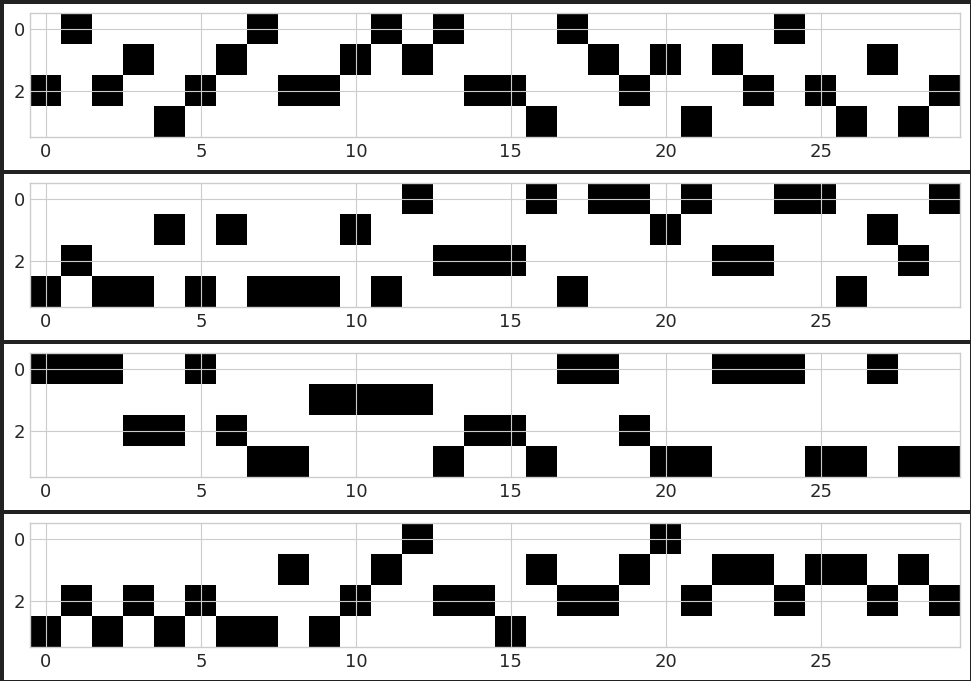

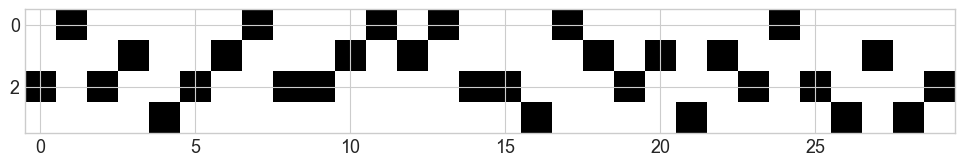

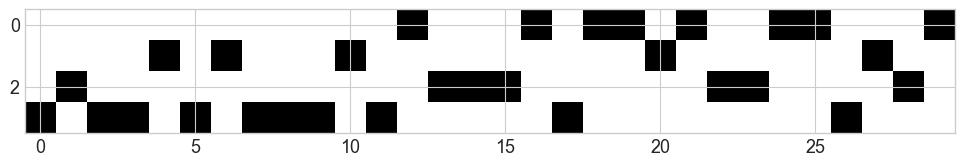

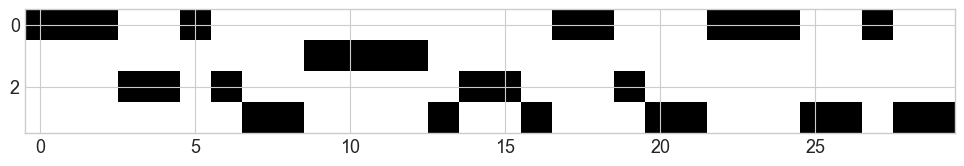

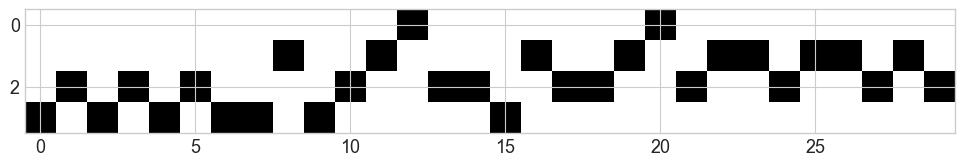

In [139]:
for i in [957, 562, 875, 566]:
    fig = plt.figure(figsize=(12,2))
    plt.imshow(X_train[i].T)

Visualization of training label (see expected result below).
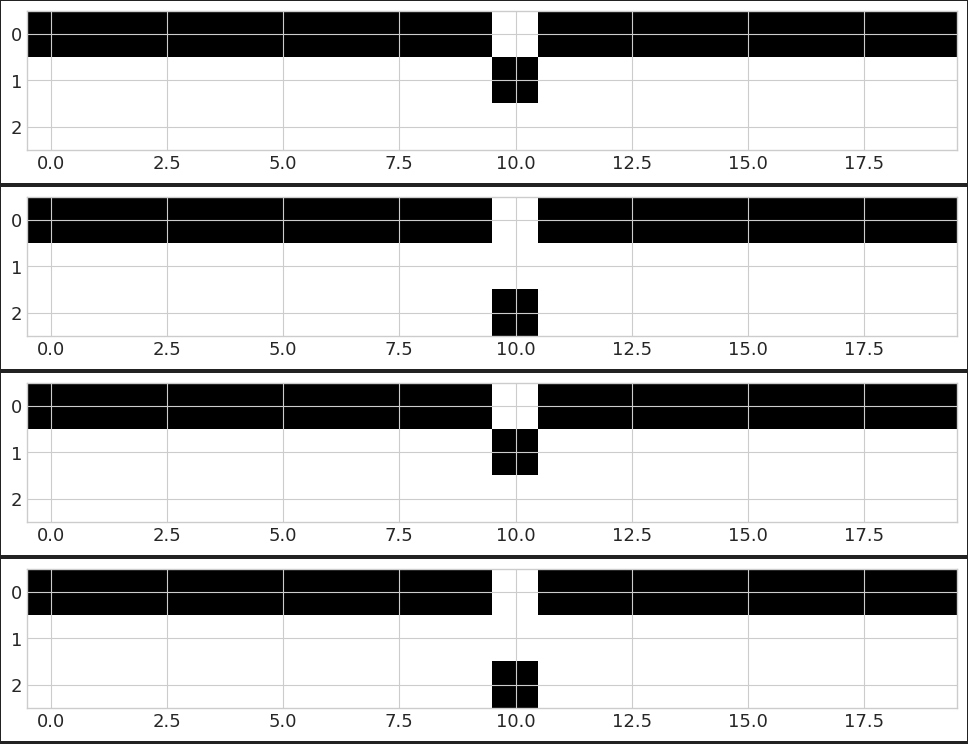

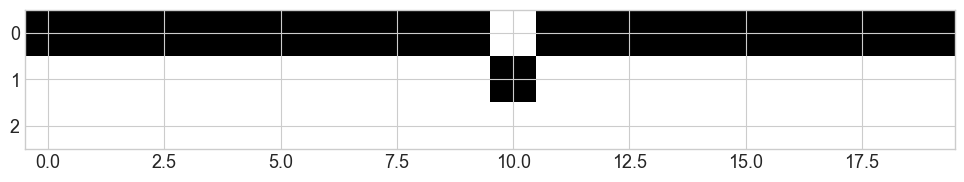

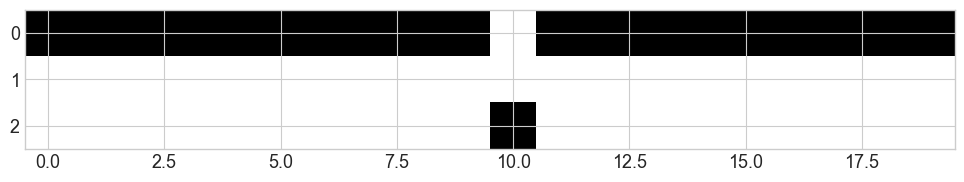

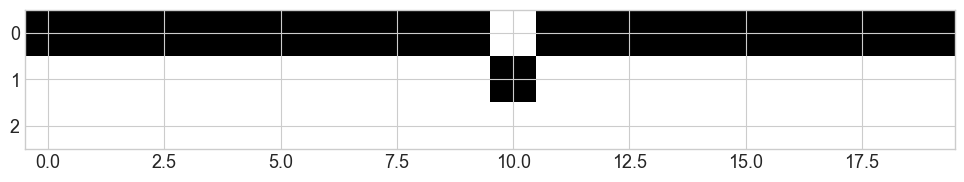

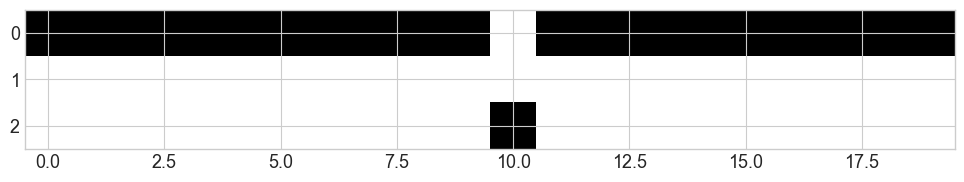

In [140]:
for i in [957, 562, 875, 566]:
    fig = plt.figure(figsize=(12,2))
    plt.imshow(Y_train[i])

Visualization of donor motifs (see expected result below).
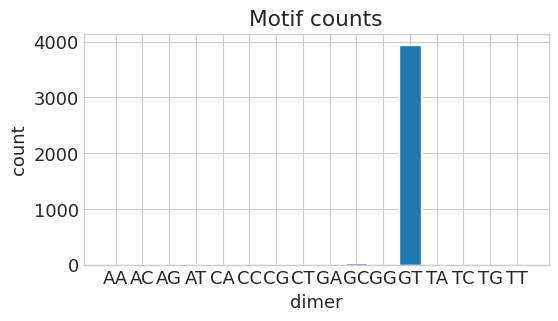

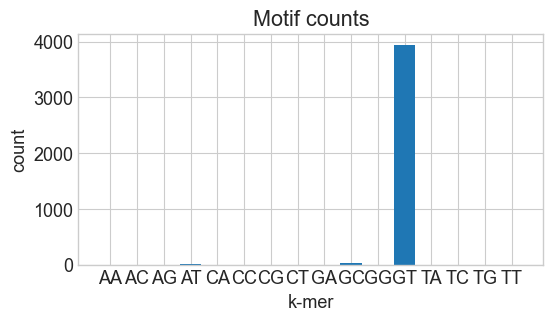

In [141]:
barplot_motifs(md_train)

Visualization of acceptor motifs (see expected result below).
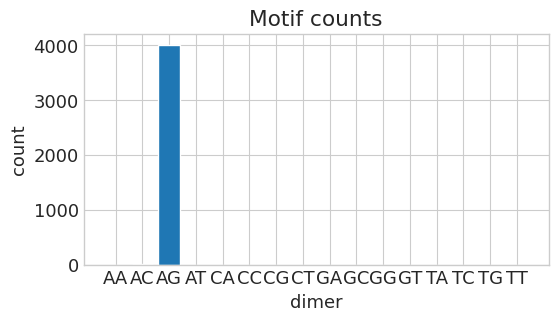


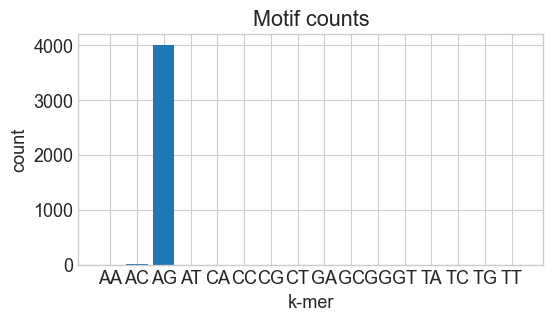

In [142]:
barplot_motifs(ma_train)

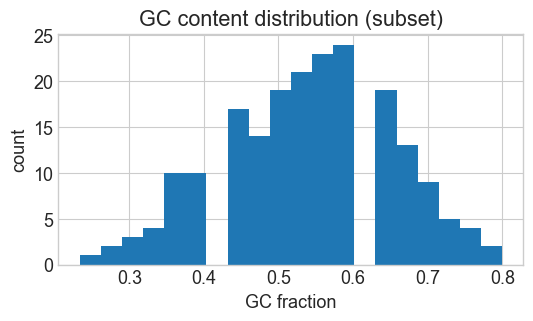

Channel totals (A,C,G,T): [1286, 1579, 1662, 1473]


In [143]:

def gc_content_from_onehot(X):
    # X: (L,4) in A,C,G,T order
    if not isinstance(X, np.ndarray) or X.ndim!=2 or X.shape[1]!=4:
        return None
    C = X[:,1].sum(); G = X[:,2].sum()
    A = X[:,0].sum(); T = X[:,3].sum()
    total = (A+C+G+T)
    if total == 0: return None
    return float(C+G)/float(total)

def summarize_batch(X_list, max_items=200):
    if not X_list:
        print("Empty X list"); return
    gc_vals = []
    ch_sums = np.zeros(4, dtype=np.int64)
    for X in X_list[:max_items]:
        if isinstance(X, np.ndarray) and X.ndim==2 and X.shape[1]==4:
            gc = gc_content_from_onehot(X)
            if gc is not None: gc_vals.append(gc)
            ch_sums += X.sum(0).astype(np.int64)
    if gc_vals:
        plt.figure(figsize=(6,3))
        plt.hist(gc_vals, bins=20)
        plt.title("GC content distribution (subset)"); plt.xlabel("GC fraction"); plt.ylabel("count"); plt.show()
    print("Channel totals (A,C,G,T):", ch_sums.tolist())

# Run if we have in-memory X; else skip (NPZ handled above)
if "X_train" in globals() and len(globals().get("X_train", []))>0:
    summarize_batch(X_train, max_items=200)
else:
    print("X_train not in memory — skip GC summary (load NPZ above if needed).")



### Reference
* https://github.com/Illumina/SpliceAI
* https://github.com/Kuanhao-Chao/OpenSpliceAI